# GPflow

In [232]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import tensorflow_probability as tfp

from gpflow.utilities import print_summary
from gpflow.config import default_float
from gpflow.ci_utils import ci_niter, is_continuous_integration

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

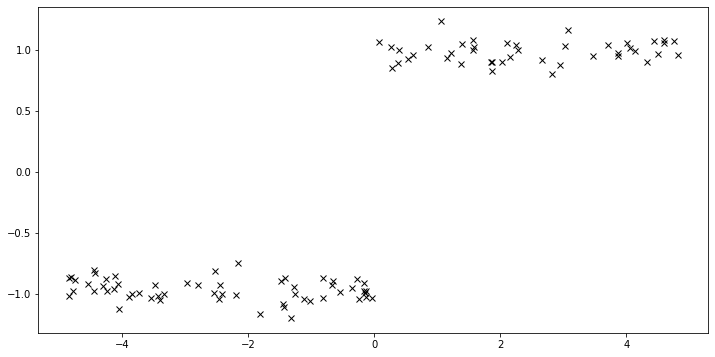

In [147]:
def f(x): 
    #return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())
    return tf.math.sign(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())

num_train_data, num_test_data = 100, 500

X = -5 + tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = -5 + tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = f(X)
Ytest = f(Xtest)

data = (X, Y)

plt.plot(X, Y, 'xk')
plt.show()

In [148]:
k1 = gpflow.kernels.SquaredExponential(0.01, 1)
k2 = gpflow.kernels.SquaredExponential(0.01, 1)
k = gpflow.kernels.ChangePoints(kernels = [k1, k2], locations = [0], steepness=1000)
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)

In [133]:
# print_summary(k)

In [134]:
#meanf = gpflow.mean_functions.Linear()

In [107]:
# print_summary(m)



In [112]:
m.likelihood.variance.assign(0.01)
m.kernel.lengthscale.assign(1)

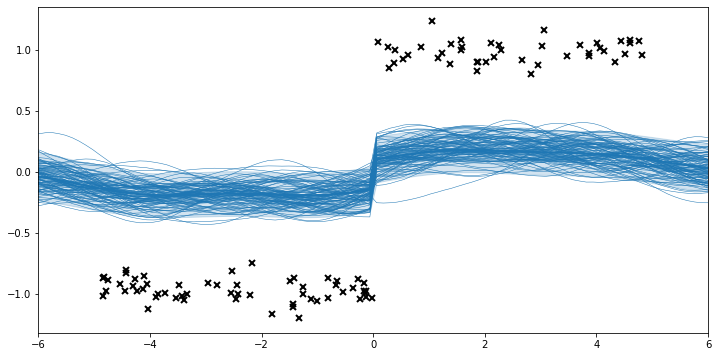

In [150]:
## generate test points for prediction
xlim = (-6,6)
xx = np.linspace(*xlim, 100).reshape((-1, 1))  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.plot(X, Y, 'kx', mew=2)
plt.xlim(*xlim);



In [151]:
opt = gpflow.optimizers.Scipy()

In [152]:
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

name                               class      transform    trainable    shape    dtype    value
---------------------------------  ---------  -----------  -----------  -------  -------  ---------------------
GPR.kernel.kernels[0].variance     Parameter  Softplus     True         ()       float64  0.9204334804310251
GPR.kernel.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64  98.47517192963022
GPR.kernel.kernels[1].variance     Parameter  Softplus     True         ()       float64  0.9649080589655444
GPR.kernel.kernels[1].lengthscale  Parameter  Softplus     True         ()       float64  16743.628839371584
GPR.kernel.locations               Parameter               True         (1,)     float64  [0.05792582]
GPR.kernel.steepness               Parameter  Softplus     True         ()       float64  1000.0000019283775
GPR.likelihood.variance            Parameter  Softplus     True         ()       float64  0.0076464381332230266


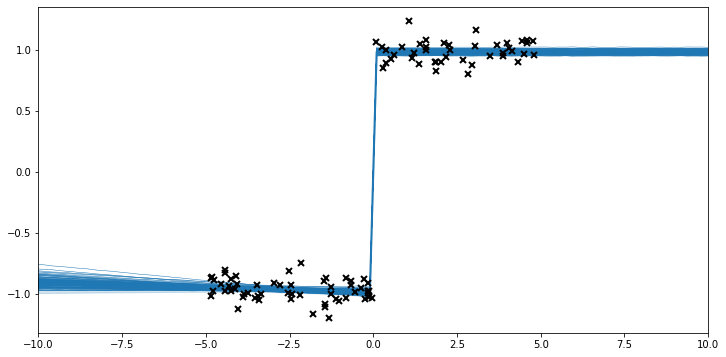

In [154]:
## generate test points for prediction
xlim = (-10,10)
xx = np.linspace(*xlim, 100).reshape((-1, 1))  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.plot(X, Y, 'kx', mew=2)
plt.xlim(*xlim);



## Simulated Motorcycle Accident 

In [155]:
import pandas as pd

In [156]:
# Load the data
# measurements of head acceleration in a simulated motorcycle accident,
mcycle = pd.read_csv(
   "mcycle.csv", 
    dtype=np.float64,
    sep=";",
    decimal=","
)

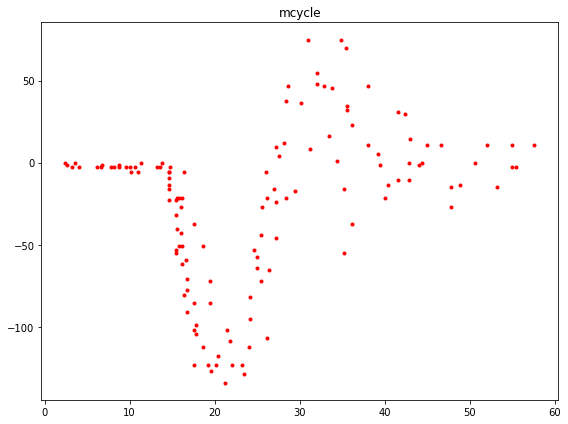

In [157]:
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(mcycle['times'],mcycle['accel'], 'r.')
ax1.set_title('mcycle')

plt.tight_layout()
plt.show()

In [158]:
X_train = mcycle.loc[:,"times"].ravel().reshape((-1,1))
y_train = mcycle.loc[:,"accel"].ravel().reshape((-1,1))
X_test = np.linspace(0, 70, num=200).reshape((-1,1))

In [169]:
k = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=4.0) + gpflow.kernels.White(variance=1.0)

In [170]:
m = gpflow.models.GPR(data=(X_train, y_train), kernel=k, mean_function=None)

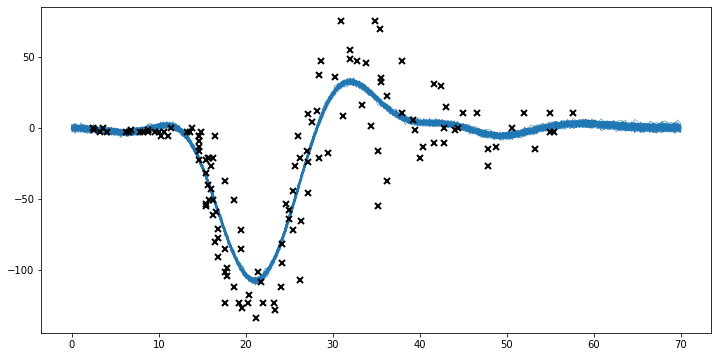

In [173]:
## generate test points for prediction
xlim = (-2,12)
xx = np.linspace(*xlim, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(X_test)

## generate 10 samples from posterior
samples = m.predict_f_samples(X_test, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X_test, mean, 'C0', lw=2)
plt.fill_between(X_test[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(X_test, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.plot(X_train, y_train, 'kx', mew=2)
#plt.xlim(*xlim);



In [174]:
opt = gpflow.optimizers.Scipy()

In [175]:
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

name                               class      transform    trainable    shape    dtype         value
---------------------------------  ---------  -----------  -----------  -------  -------  ----------
GPR.kernel.kernels[0].variance     Parameter  Softplus     True         ()       float64  2046.65
GPR.kernel.kernels[0].lengthscale  Parameter  Softplus     True         ()       float64     5.24044
GPR.kernel.kernels[1].variance     Parameter  Softplus     True         ()       float64   254.319
GPR.likelihood.variance            Parameter  Softplus     True         ()       float64   254.319


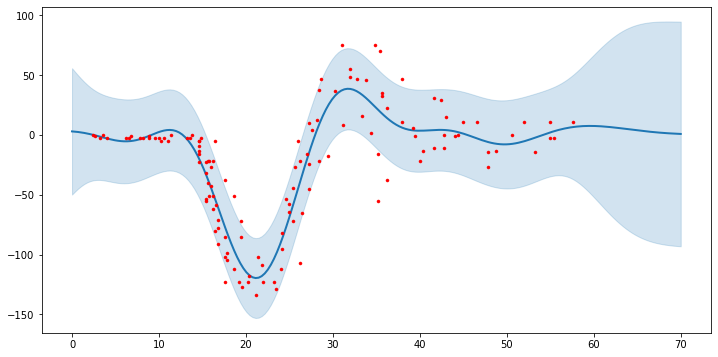

In [180]:
## generate test points for prediction
xlim = (-2,12)
xx = np.linspace(*xlim, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(X_test)

## generate 100 samples from posterior
samples = m.predict_f_samples(X_test, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X_test, mean, 'C0', lw=2)
plt.fill_between(X_test[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

#plt.plot(X_test, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.plot(X_train, y_train, 'r.', mew=.5)
#plt.xlim(*xlim);



## AirPassenger

As a first real world example we will fit a GP to the airline passenger dataset. (Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.).

In [203]:
# Air Passenger Data
y=np.array([112.0, 118, 132, 129, 121,135, 148, 148, 136, 119, 104, 118,
 115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140,
 145, 150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166,
 171, 180, 193, 181, 183, 218, 230, 242, 209, 191, 172, 194,
 196, 196, 236, 235, 229, 243, 264, 272, 237, 211, 180, 201,
 204, 188, 235, 227, 234, 264, 302, 293, 259, 229, 203, 229,
 242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
 284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306,
 315, 301, 356, 348, 355, 422, 465, 467, 404, 347, 305, 336,
 340, 318, 362, 348, 363, 435, 491, 505, 404, 359, 310, 337,
 360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405,
 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432], dtype=np.float64).reshape((-1,1))
X=np.arange(y.shape[0], dtype=np.float64).reshape((-1,1))

date=pd.date_range('1949-01-01','1960-12-01', 
              freq='MS')

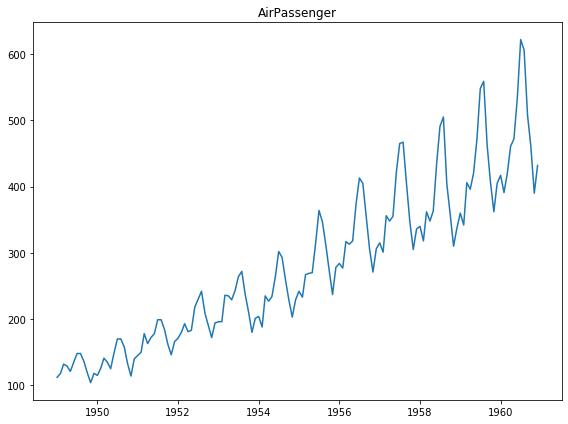

In [205]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(date, y)
ax.set_title('AirPassenger')

plt.tight_layout()
plt.show()

Due to the increasing variance we fit a GP to the log-transformed data. MEAN FUNCTION!

Using the [marginalisation property](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Marginal_distributions) of multivariate Gaussians, the joint distribution over the observations, $\mathbf{y}$, and test outputs $\mathbf{f_*}$ according to the GP prior is
$$\begin{bmatrix} \mathbf{y} \\ \mathbf{f}_* \end{bmatrix} = \mathcal{N}\left(\begin{bmatrix} \mu_{y}\\ \mu_{\mathbf{f}_*}\end{bmatrix}, \begin{bmatrix} K(X, X)  + \sigma_n^2I && K(X, X_*) \\ K(X_*, X) && K(X_*, X_*)\end{bmatrix}\right).$$

FORMEL ANPASSEN

The GP posterior is found by conditioning the joint G.P prior distribution on the observations
$$\mathbf{f}_* | X_*, X, \mathbf{y} \sim \mathcal{N}\left(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*)\right),$$

where 
\begin{align*}
\bar{\mathbf{f}}_* &= K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}\mathbf{y} \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)\left[K(X, X) + \sigma_n^2\right]^{-1}K(X, X_*).
\end{align*}

Although $\bar{\mathbf{f}}_*$ and $\text{cov}(\mathbf{f}_*)$ look nasty, they follow the the standard form for the mean and covariance of a conditional Gaussian distribution, and can be derived relatively straightforwardly (see [here](https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution)).

In [223]:
h=24
X_train=X[:-h]
X_test=np.arange(-h,len(X_train)+h, dtype=float).reshape((-1,1))
y_train=y[:-h]

In [214]:
X_train

array([[  0.],
       [  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 19.],
       [ 20.],
       [ 21.],
       [ 22.],
       [ 23.],
       [ 24.],
       [ 25.],
       [ 26.],
       [ 27.],
       [ 28.],
       [ 29.],
       [ 30.],
       [ 31.],
       [ 32.],
       [ 33.],
       [ 34.],
       [ 35.],
       [ 36.],
       [ 37.],
       [ 38.],
       [ 39.],
       [ 40.],
       [ 41.],
       [ 42.],
       [ 43.],
       [ 44.],
       [ 45.],
       [ 46.],
       [ 47.],
       [ 48.],
       [ 49.],
       [ 50.],
       [ 51.],
       [ 52.],
       [ 53.],
       [ 54.],
       [ 55.],
       [ 56.],
       [ 57.],
       [ 58.],
       [ 59.],
       [ 60.],
       [ 61.],
       [ 62.],
       [ 63.],
       [ 64.],
       [ 65.],
       [ 6

In [226]:
k1 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=4.0)*gpflow.kernels.Periodic(period=12.0)
k2 = gpflow.kernels.White()
k3 = gpflow.kernels.SquaredExponential(variance=1.0, lengthscale=90.0)
k = k1 + k2 + k3

m = gpflow.models.GPR((X_train, y_train), kernel=k, mean_function=None)

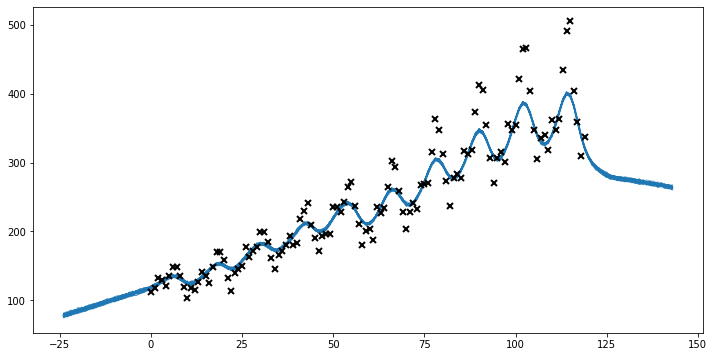

In [227]:
## generate test points for prediction
xlim = (-2,12)
xx = np.linspace(*xlim, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(X_test)

## generate 10 samples from posterior
samples = m.predict_f_samples(X_test, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X_test, mean, 'C0', lw=2)
plt.fill_between(X_test[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(X_test, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.plot(X_train, y_train, 'kx', mew=2)
#plt.xlim(*xlim);



In [228]:
opt = gpflow.optimizers.Scipy()

In [229]:
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

name                                          class      transform    trainable    shape    dtype         value
--------------------------------------------  ---------  -----------  -----------  -------  -------  ----------
GPR.kernel.kernels[0].kernels[0].variance     Parameter  Softplus     True         ()       float64  203.072
GPR.kernel.kernels[0].kernels[0].lengthscale  Parameter  Softplus     True         ()       float64  118.47
GPR.kernel.kernels[0].kernels[1].variance     Parameter  Softplus     True         ()       float64  203.072
GPR.kernel.kernels[0].kernels[1].lengthscale  Parameter  Softplus     True         ()       float64    0.681749
GPR.kernel.kernels[0].kernels[1].period       Parameter  Softplus     True         ()       float64   12.0307
GPR.kernel.kernels[1].variance                Parameter  Softplus     True         ()       float64   60.1852
GPR.kernel.kernels[2].variance                Parameter  Softplus     True         ()       float64  104.227
GPR.kerne

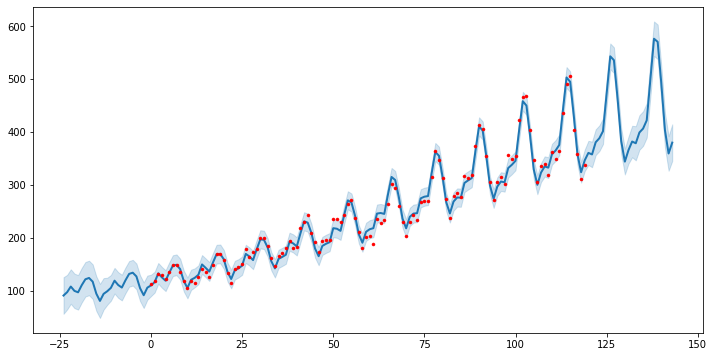

In [230]:
## generate test points for prediction
xlim = (-2,12)
xx = np.linspace(*xlim, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(X_test)

## generate 100 samples from posterior
samples = m.predict_f_samples(X_test, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(X_test, mean, 'C0', lw=2)
plt.fill_between(X_test[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

#plt.plot(X_test, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.plot(X_train, y_train, 'r.', mew=.5)
#plt.xlim(*xlim);



# MCMC

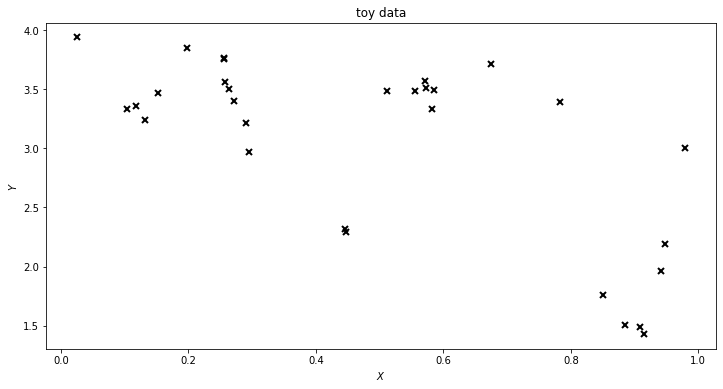

In [233]:
N = 30
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
data = (X, Y)

plt.figure(figsize=(12,6))
plt.plot(X, Y, 'kx', mew=2)
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('toy data')
plt.show()

In [247]:
kernel = gpflow.kernels.Matern52(lengthscale=0.3)

meanf = gpflow.mean_functions.Linear(1.0, 0.0)
model = gpflow.models.GPR(data, kernel, meanf)
model.likelihood.variance.assign(0.01)

In [248]:
optimizer = gpflow.optimizers.Scipy()

@tf.function(autograph=False)
def objective():
    return - model.log_marginal_likelihood()
optimizer.minimize(objective, variables=model.trainable_variables)

print(f'log likelihood at optimum: {model.log_likelihood()}')

log likelihood at optimum: -0.9943047580069546


In [249]:
# tfp.distributions dtype is inferred from parameters - so convert to 64-bit
model.kernel.lengthscale.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.kernel.variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.likelihood.variance.prior = tfp.distributions.Gamma(f64(1.), f64(1.))
model.mean_function.A.prior = tfp.distributions.Normal(f64(0.), f64(10.))
model.mean_function.b.prior = tfp.distributions.Normal(f64(0.), f64(10.))

gpflow.utilities.print_summary(model)

name,class,transform,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,,True,"(1, 1)",float64,[[-0.86214943]]
GPR.mean_function.b,Parameter,,True,(),float64,3.6257345589948584
GPR.kernel.variance,Parameter,Softplus,True,(),float64,0.6022881749664336
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.08570021618985625
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,0.007140029229562104


In [250]:
hmc_helper =  gpflow.optimizers.SamplingHelper(
    model.trainable_parameters,
    model.log_marginal_likelihood
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=10,
    step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc,
    num_adaptation_steps=10,
    target_accept_prob=f64(0.75),
    adaptation_rate=0.1
)

num_samples = 5000

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=300,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn = lambda _, pkr: pkr.inner_results.is_accepted
    )

samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_constrained_values(samples)

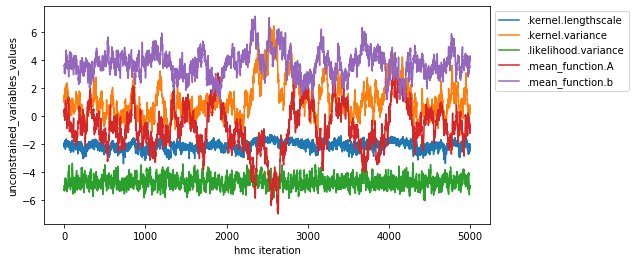

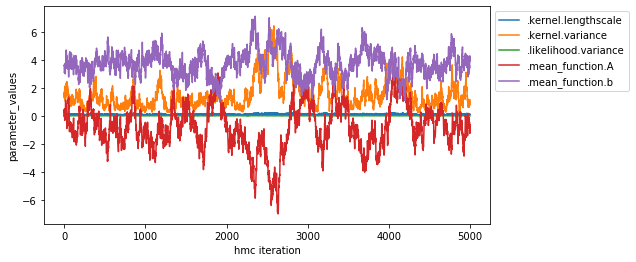

In [251]:
param_to_name = {param: name for name, param in
                 gpflow.utilities.parameter_dict(model).items()}

def plot_samples(samples, y_axis_label):

    plt.figure(figsize=(8,4))
    for val, param in zip(samples,  model.parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1., 1.))
    plt.xlabel('hmc iteration')
    plt.ylabel(y_axis_label);


plot_samples(samples, 'unconstrained_variables_values')
plot_samples(parameter_samples, 'parameter_values')

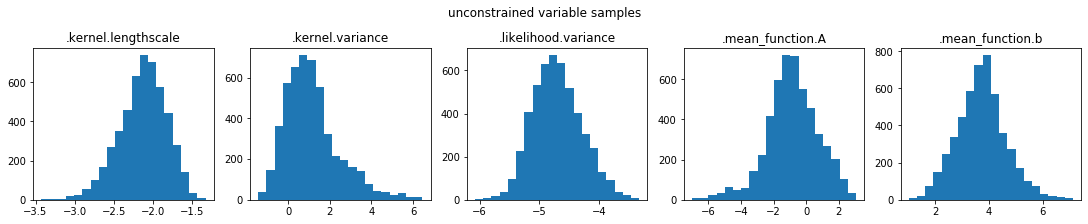

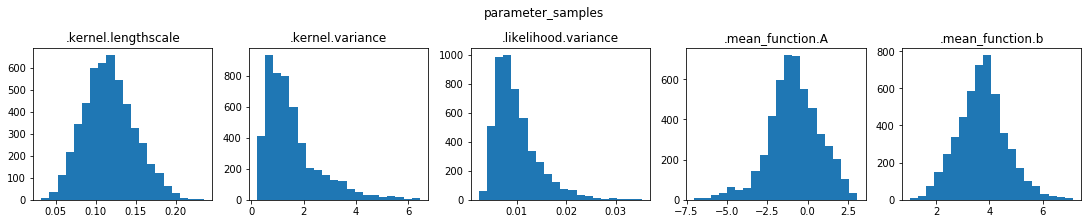

In [252]:
def marginal_samples(samples, y_axis_label):
    fig, axarr = plt.subplots(1, len(param_to_name), figsize=(15,3), constrained_layout=True)
    for i, param in enumerate(model.trainable_parameters):
        ax = axarr[i]
        ax.hist(np.stack(samples[i]).reshape(-1,1),bins=20)
        ax.set_title(param_to_name[param])
    fig.suptitle(y_axis_label);
    plt.show()
marginal_samples(samples, 'unconstrained variable samples')
marginal_samples(parameter_samples, 'parameter_samples')


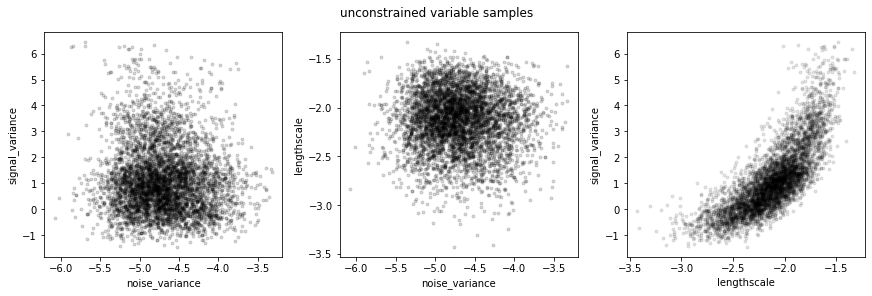

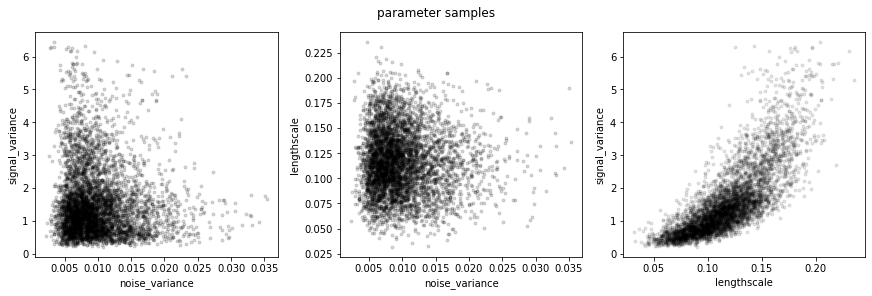

In [253]:
name_to_index = {param_to_name[param]: i for i, param in
                 enumerate(model.trainable_parameters)}

def plot_joint_marginals(samples, y_axis_label):
    f, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

    axs[0].plot(samples[name_to_index['.likelihood.variance']],
                samples[name_to_index['.kernel.variance']], 'k.', alpha = 0.15)
    axs[0].set_xlabel('noise_variance')
    axs[0].set_ylabel('signal_variance')

    axs[1].plot(samples[name_to_index['.likelihood.variance']],
                samples[name_to_index['.kernel.lengthscale']], 'k.', alpha = 0.15)
    axs[1].set_xlabel('noise_variance')
    axs[1].set_ylabel('lengthscale')

    axs[2].plot(samples[name_to_index['.kernel.lengthscale']],
                samples[name_to_index['.kernel.variance']], 'k.', alpha = 0.1)
    axs[2].set_xlabel('lengthscale')
    axs[2].set_ylabel('signal_variance')
    f.suptitle(y_axis_label);
    plt.show()

plot_joint_marginals(samples, 'unconstrained variable samples')
plot_joint_marginals(parameter_samples, 'parameter samples')

In [255]:
gpflow.utilities.print_summary(model)

name,class,transform,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,,True,"(1, 1)",float64,[[-0.64029863]]
GPR.mean_function.b,Parameter,,True,(),float64,3.9385871161882124
GPR.kernel.variance,Parameter,Softplus,True,(),float64,1.1547609375265082
GPR.kernel.lengthscale,Parameter,Softplus,True,(),float64,0.10116602245009175
GPR.likelihood.variance,Parameter,Softplus,True,(),float64,0.0067559986582926106


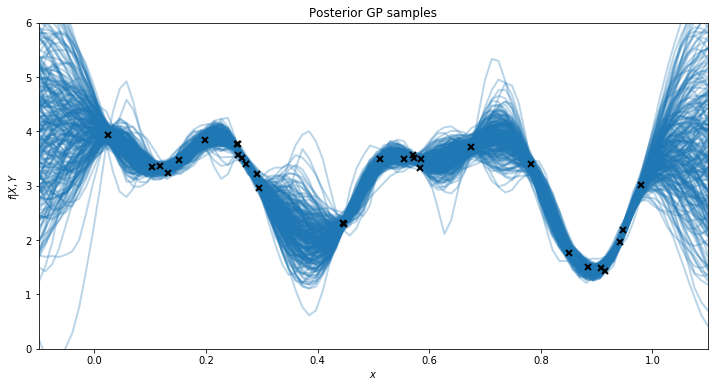

In [256]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))

for i in range(0, num_samples, 20):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.3)

plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel('$x$')
plt.ylabel('$f|X,Y$')
plt.title('Posterior GP samples')

plt.show()
